In [2]:
###aplicacion de modelos de Kereszturi et al. 2025 (PLSR y SVR) a datos de morfometria de centros eruptivos menores (CEMs) de rapanui; 
###se usaron solo las variables mas completas obtenidas de los CEMs de rapnui, dado que son pocos el codigo lanza errores en algunas secciones, pero  
###es por los parametros de ejes para plotear que son por que el codigo original es aplicado a una gran variedad de variables no asi en el de rapanui.
###el modelo es entrenado con los datos originales de Kereszturi y despues del bloque de entrenamiento viene la aplicacion del modelo para predecir 
###edades;;;; dado el tiempo solo se hizo uso del modelo y no se calcularon otras variables como por ejemplo las VIPs u otros parametros del trabajo original;
###este codigo es propiedad intelectual de kereszturi et al. 2025 y solo fue usado con fines academicos para evaluar su uso en rapanui. 

# This code pre-process morphometric, climatic and satellite data and fits three multivariate models to 
# predict eruption ages of scoria cones.
# This code was used in Kereszturi et al. 2025 - Understanding the evolution of scoria cone morphology using multivariate models
# Corresponding authors: Gabor Kereszturi (email: g.kereszturi@massey.ac.nz)
#########################################################################################################
#########################################################################################################
#########################################################################################################


### Import libraries and data from Excel
import os
import numpy as np
import pandas as pd
from pathlib import Path
  

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.io as pio
pio.kaleido.scope


path = r'C:\Users\56931\Downloads' # Input folder with the database
os.chdir(path)

inputFile = 'Cinder_DATA_cones.xlsx' # Input excel with the data
inputSheet = 'variables'
inputName = Path(str(inputFile)).stem

random_state = 1

### Target variable
target_parameter = 'Age'
units = 'ky'

### Predictor variables
M = ['BaseHco', 'BaseWco', 'BaseVol', 'FlSlopeMean', 'HcoWcoMean']
MS = ['BaseHco', 'BaseWco', 'BaseRound', 'BaseCirc', 'BaseAspRat',  'BaseSolid', 'CrWcr', 'CrDepthMax', 'CrRound', 'CrCirc', 'CrAspRat',  'CrSolid', 'BaseVol', 'HcoWcoPre', 'HcoWcoMean', 'WcoWcr', 'CrFillVolMax', 'CrVol', 'FlSlopeMax', 'FlSlopeMean', 'FlSlopeStdDev', 'FlSlopeMed', 'FlIrrMax', 'FlIrrMean', 'FlIrrStdDev', 'FlIrrMed', 'CrSlopeMax', 'CrSlopeMean', 'CrSlopeStdDev', 'CrSlopeMed', 'CrIrrMax', 'CrIrrMean', 'CrIrrStdDev', 'CrIrrMed', 'S2B1', 'S2B2', 'S2B3', 'S2B4', 'S2B5', 'S2B6', 'S2B7', 'S2B8', 'S2B9', 'S2B11', 'S2B12']
MSC = ['BaseHco', 'BaseWco', 'BaseRound', 'BaseCirc', 'BaseAspRat',  'BaseSolid', 'CrWcr', 'CrDepthMax', 'CrRound', 'CrCirc', 'CrAspRat',  'CrSolid', 'BaseVol', 'HcoWcoPre', 'HcoWcoMean', 'WcoWcr', 'CrFillVolMax', 'CrVol', 'FlSlopeMax', 'FlSlopeMean', 'FlSlopeStdDev', 'FlSlopeMed', 'FlIrrMax', 'FlIrrMean', 'FlIrrStdDev', 'FlIrrMed', 'CrSlopeMax', 'CrSlopeMean', 'CrSlopeStdDev', 'CrSlopeMed', 'CrIrrMax', 'CrIrrMean', 'CrIrrStdDev', 'CrIrrMed', 'S2B1', 'S2B2', 'S2B3', 'S2B4', 'S2B5', 'S2B6', 'S2B7', 'S2B8', 'S2B9', 'S2B11', 'S2B12', 'ClimBio1', 'ClimBio2', 'ClimBio3', 'ClimBio4', 'ClimBio5', 'ClimBio6', 'ClimBio7', 'ClimBio8', 'ClimBio9', 'ClimBio10', 'ClimBio11', 'ClimBio12', 'ClimBio13', 'ClimBio14', 'ClimBio15', 'ClimBio16', 'ClimBio17', 'ClimBio18', 'ClimBio19', 'GloREDa']
predictor_parameter = M #M , MS, MSC
predictor_parameter_text = 'M' #M , MS, MSC

### Ancillary information
general_parameter= ['GIS_ID', 'ConeName', 'Idsample', 'VolcanicField', 'Country', 'Group', 'Latitude', 'Longitude',
                    'SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5',
                    'Age', 'AgeError', 'AgeErrorBarReported', 'AgeErrorBarAssumed', 'AgeErrorReCalc1STD', 'AgeErrorReCalc2STD', 'AgeErrorPerc',
                    'AgeUpper', 'AgeLower', 'AgeMethod', 'AgeDatedMaterial', 'AgeReference', 'AgePublication',
                    'DEMType', 'DEMResolution', 'ErHistPhreato', 'ErHistLava', 'MorphString', 'MorphSimple', 'MorphBreached',
                    'MorphComplex', 'MorphAll', 'GeneralComments', 'PlateName', 'PlateBonduary', 'PlateVelocityDivergence',
                    'PlateSeaFloorAge', 'PlateType', 'PlateDistance', 'PlateAbsoluteVelocity', 'CrustPwave', 'CrustMohoDepth']

### Unprocessed scoria cone database
df_unprocessed = pd.read_excel(inputFile, sheet_name=inputSheet, header=0).set_index('ID')
df_unprocessed.insert(loc=0, column='GIS_ID', value=df_unprocessed.index.values)
df_unprocessed = df_unprocessed[df_unprocessed['MorphAll'] == 1]

In [3]:
### Log-transformation and scaling on predictor variables
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)

transformer = FunctionTransformer(np.log)
InvTransformer = FunctionTransformer(np.exp)

X = pd.DataFrame(transformer.transform(df_unprocessed.loc[:,predictor_parameter]), 
                 columns=df_unprocessed.loc[:,predictor_parameter].columns, index=df_unprocessed.index)

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

df_scaled = df_unprocessed.loc[:,general_parameter].merge(X_scaled, on='ID', sort=False)
print(r'Total number of predictor variables: {}'.format(len(predictor_parameter)))
print('------')

### Filtering and splitting into training/validation and independent hold-out validation datasets
import random

### Exclude cones with less accurate absolute age
exclude = 25 #percentage

df_scaled_filtered = df_scaled[(df_scaled['AgeErrorPerc'] < exclude)]
df_scaled_excluded = df_scaled[(df_scaled['AgeErrorPerc'] > exclude)]    

### Splitting data to training and validation populations 
frac_split = 0.8

df_scaled_train = df_scaled_filtered.sample(frac=frac_split, random_state=random_state)
df_scaled_val = df_scaled_filtered.drop(index=df_scaled_train.index)

print(r'Total number of cones: {}'.format(len(df_unprocessed)))
print(r'Total number of training: {}'.format(len(df_scaled_train)))
print(r'Total number of validation: {}'.format(len(df_scaled_val)))
print(r'Total number of excluded cones: {}'.format(len(df_scaled_excluded)))

Total number of predictor variables: 5
------
Total number of cones: 262
Total number of training: 161
Total number of validation: 40
Total number of excluded cones: 60


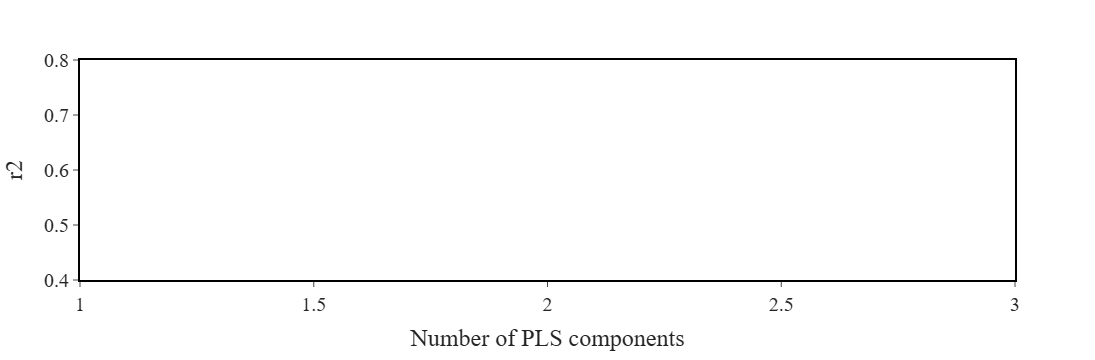

In [4]:
# Partial Least Squares Regression model (PLSR)
#########################################################################################################
#########################################################################################################
#########################################################################################################

### Optimizing number of PLS components using KFold (k=3) cross-validation
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

pio.templates.default = 'simple_white'
font_type = 'DejaVu Sans'
font_size = 20

PLSR_method = 'PLSR'
target_parameter_PLSR = ['Age', 'AgeLower', 'AgeUpper']
n_splits = 3

### Input X and Y variables with transformation and validation data
df_scaled_train_X = df_scaled_train.loc[:,predictor_parameter]
df_scaled_train_Y = pd.DataFrame(transformer.transform(df_scaled_train.loc[:,target_parameter_PLSR]))

df_scaled_validation_X = df_scaled_val.loc[:,predictor_parameter]

df_scaled_excluded_X = df_scaled_excluded.loc[:,predictor_parameter]

### Calculating PLSR with different number of components from 1 to 15
maxComp = min(df_scaled_train_X.shape[0], df_scaled_train_X.shape[1], df_scaled_train_Y.shape[1])
iteration = np.arange(1, maxComp+1, 1)


error = []
error_metric = 'r2'

model_PLSR_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
model_PLSR_cv.get_n_splits(df_scaled_train_X, df_scaled_train_Y)

for i in iteration:
    PLS = PLSRegression(n_components=i)

    temp = cross_val_score(PLS, df_scaled_train_X, df_scaled_train_Y, scoring=error_metric, cv=model_PLSR_cv, n_jobs=-1)
    error.append(np.mean(temp))

error_plot_PLSR = pd.DataFrame(np.vstack(error), columns=[error_metric], index=iteration)

### Plotting error metric as a function of components
PLSR_error_plot = px.line(x=error_plot_PLSR.loc[:,error_metric].index, y=error_plot_PLSR.loc[:,error_metric])
PLSR_error_plot.update_layout(yaxis_range=[0.4,0.8],
                         xaxis = dict(title='Number of PLS components',
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       yaxis = dict(title='{}'.format(error_metric),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       font=dict(size=font_size, family=font_type),
                       legend_itemsizing='constant',
                       legend=dict(yanchor='middle',
                                   y=0.2, x=0.8),
                       coloraxis_colorbar=dict(thicknessmode='pixels', 
                                               thickness=50,
                                               lenmode='pixels',
                                               len=150,
                                               yanchor='middle',
                                               y=0.2, x=0.8))
PLSR_error_plot.write_image(r'{}_{}_{}_PLScomponents.svg'.format(inputName, predictor_parameter_text, PLSR_method), format='svg', width=950, height=450, scale=1)
PLSR_error_plot.show()

In [5]:
### Prediction using PLSR model with user-defined PLS components, and reporting error metrics and plots
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

max_components = min(df_scaled_train_X.shape[0], df_scaled_train_X.shape[1], df_scaled_train_Y.shape[1])
PLScomp = min(error_plot_PLSR.idxmax()[0], max_components)


PLSR_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
PLSR_cv.get_n_splits(df_scaled_train_X)

PLSR = PLSRegression(n_components=PLScomp)
PLSR.fit(df_scaled_train_X, df_scaled_train_Y)

### K-fold cross-validation
PLSR_cv_r2 = cross_val_score(PLSR, df_scaled_train_X, df_scaled_train_Y, scoring='r2', cv=PLSR_cv, n_jobs=-1)
print(r'PLSR - Mean R2cv from {}-fold: {:0.3f}'.format(n_splits, np.mean(PLSR_cv_r2)))

PLSR_cv_MAPE = cross_val_score(PLSR, df_scaled_train_X, df_scaled_train_Y, scoring='neg_mean_absolute_percentage_error', cv=PLSR_cv, n_jobs=-1)
print(r'PLSR - Mean MAPEcv from {}-fold: {:0.2f}% (in log-space)'.format(n_splits, np.mean(- PLSR_cv_MAPE*100)))

PLSR_cv_predicted = pd.DataFrame(InvTransformer.transform(
    cross_val_predict(PLSR, df_scaled_train_X, df_scaled_train_Y, cv=PLSR_cv, n_jobs=-1)),
    columns=['{}_trainCV_{}'.format(PLSR_method, target_parameter),
             '{}_trainCV_AgeLower'.format(PLSR_method),
             '{}_trainCV_AgeUpper'.format(PLSR_method)
            ], index=df_scaled_train_X.index)
df_PLSR_cv_predicted = df_scaled_train.merge(PLSR_cv_predicted, on='ID', sort=False)

### Validation with independent data
PLSR_val_predicted = pd.DataFrame(InvTransformer.transform(PLSR.predict(df_scaled_validation_X)),
                                  columns=['{}_val_{}'.format(PLSR_method, target_parameter),
                                          '{}_val_AgeLower'.format(PLSR_method),
                                          '{}_val_AgeUpper'.format(PLSR_method)
                                          ], index=df_scaled_val.index)

df_PLSR_val_predicted = df_scaled_val.merge(PLSR_val_predicted, on='ID', sort=False)

PLSR_val_r2 = r2_score(transformer.transform(df_PLSR_val_predicted.loc[:,target_parameter_PLSR]),
                             PLSR.predict(df_scaled_validation_X))
print(u'PLSR - R2val using independent data: {:0.3f}'.format(PLSR_val_r2))

PLSR_val_MAPE = mean_absolute_percentage_error(transformer.transform(df_PLSR_val_predicted.loc[:,target_parameter_PLSR]),
                            PLSR.predict(df_scaled_validation_X))
print(r'PLSR - MAPEval using independent data: {:0.2f}% (in log-space)'.format(PLSR_val_MAPE*100))

PLSR_val_spearmanR = stats.spearmanr(df_PLSR_val_predicted.loc[:,target_parameter],
                             df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, target_parameter)])
print(r'PLSR - Spearman correlation coefficient using independent data: {:0.3f} (p={:0.3f})'.format(PLSR_val_spearmanR[0], PLSR_val_spearmanR[1]))

### Prediction on excluded data
PLSR_excluded_predicted = pd.DataFrame(InvTransformer.transform(PLSR.predict(df_scaled_excluded_X)),
                                  columns=['{}_excluded_{}'.format(PLSR_method, target_parameter),
                                          '{}_excluded_AgeLower'.format(PLSR_method),
                                          '{}_excluded_AgeUpper'.format(PLSR_method)
                                          ], index=df_scaled_excluded.index)

df_PLSR_excluded_predicted = df_scaled_excluded.merge(PLSR_excluded_predicted, on='ID', sort=False)

PLSR_excluded_r2 = r2_score(transformer.transform(df_PLSR_excluded_predicted.loc[:,'Age']),
                             PLSR.predict(df_scaled_excluded_X)[:,1])
print(r'PLSR - R2val on the excluded data: {:0.3f}'.format(PLSR_excluded_r2))

PLSR_excluded_MAPE = mean_absolute_percentage_error(transformer.transform(df_PLSR_excluded_predicted.loc[:,'Age']),
                            PLSR.predict(df_scaled_excluded_X)[:,1])
print(r'PLSR - MAPEval on the excluded data: {:0.2f}% (in log-space)'.format(PLSR_excluded_MAPE*100))

PLSR_excluded_spearmanR = stats.spearmanr(df_PLSR_excluded_predicted.loc[:,'Age'],
                             df_PLSR_excluded_predicted.loc[:,'{}_excluded_{}'.format(PLSR_method, target_parameter)])
print(r'PLSR - Spearman correlation coefficient on the excluded data: {:0.3f} (p={:0.3f})'.format(PLSR_excluded_spearmanR[0], PLSR_excluded_spearmanR[1]))

PLSR - Mean R2cv from 3-fold: 0.379
PLSR - Mean MAPEcv from 3-fold: 94.46% (in log-space)
PLSR - R2val using independent data: 0.495
PLSR - MAPEval using independent data: 802.45% (in log-space)
PLSR - Spearman correlation coefficient using independent data: 0.767 (p=0.000)
PLSR - R2val on the excluded data: 0.152
PLSR - MAPEval on the excluded data: 174.71% (in log-space)
PLSR - Spearman correlation coefficient on the excluded data: 0.628 (p=0.000)


C:\Users\56931\AppData\Local\Temp\ipykernel_17420\293894557.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



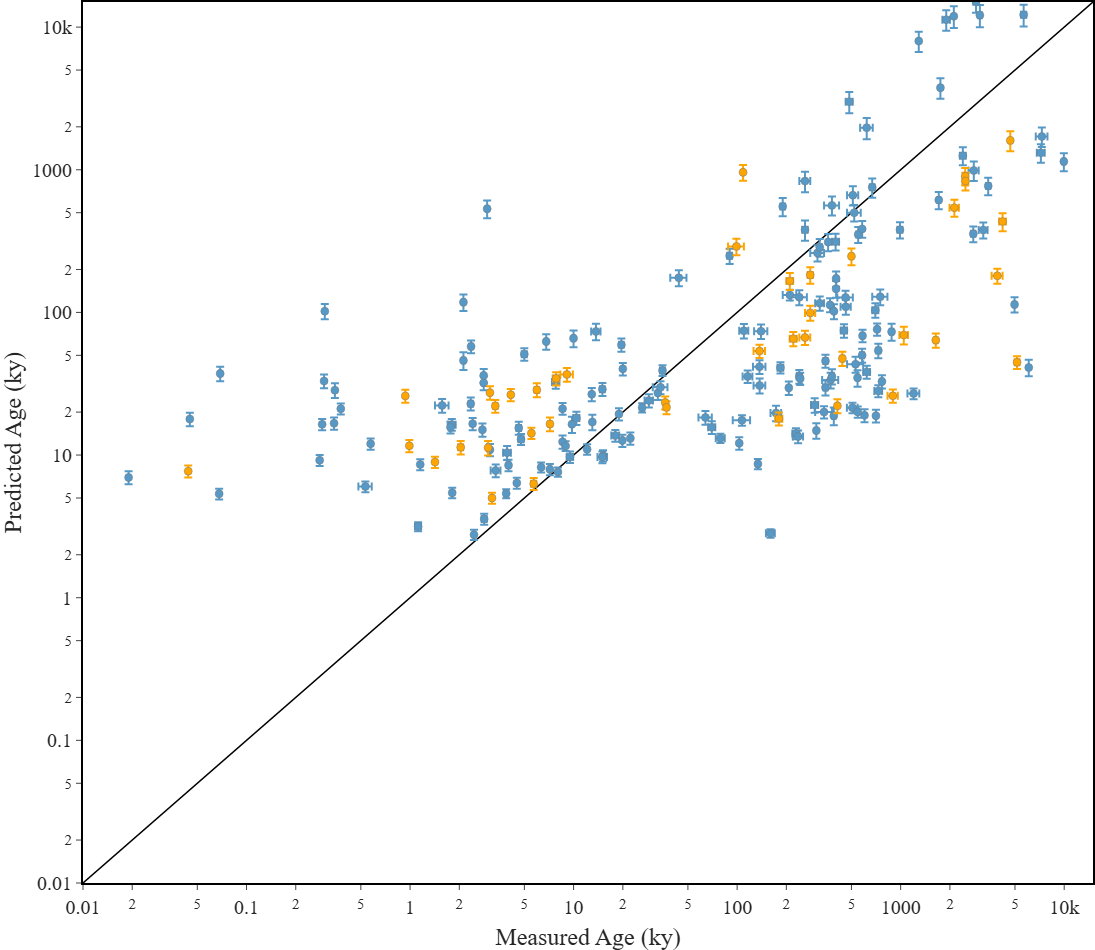

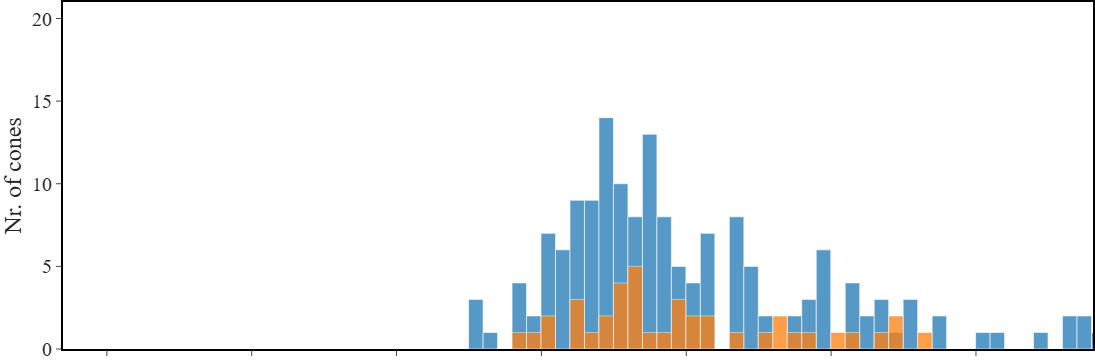

ShapeError: Expected object of length 40, got length: 161

In [6]:
### Plotting measured vs predicted graph
font_type = 'DejaVu Sans'
font_size = 20

axis_range = [0.01, 15000]
hist_axis_rangeY = [0, 21]

fig_pred_PLSR = px.line(x=axis_range, y=axis_range, range_x=axis_range, range_y=axis_range, 
                   log_x=True, log_y=True, width=950, height=950)
fig_pred_PLSR.update_traces(line_color='black', line_width=1.5)
fig_pred_PLSR.add_trace(go.Scatter(x=df_PLSR_cv_predicted.loc[:,target_parameter],
                              y=df_PLSR_cv_predicted.loc[:,'{}_trainCV_{}'.format(PLSR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_PLSR_cv_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              error_y = dict(
                                  type='data',
                                  array=df_PLSR_cv_predicted.loc[:,'{}_trainCV_{}'.format(PLSR_method, 'AgeUpper')].values - df_PLSR_cv_predicted.loc[:,'{}_trainCV_{}'.format(PLSR_method, 'AgeLower')].values,
                                  visible=True),
                              hovertext=df_PLSR_cv_predicted[['ConeName', 'Age', '{}_trainCV_{}'.format(PLSR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_PLSR_cv_predicted['ConeName'],
                              marker=dict(color='#5799c6', size=2, line=dict(color='#74797C')),
                              name='Training',
                              showlegend=False))
fig_pred_PLSR.add_trace(go.Scatter(x=df_PLSR_val_predicted.loc[:,target_parameter],
                              y=df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_PLSR_val_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              error_y = dict(
                                  type='data',
                                  array=df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, 'AgeUpper')].values - df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, 'AgeLower')].values,
                                  visible=True),
                              hovertext=df_PLSR_val_predicted[['ConeName', 'Age', '{}_val_{}'.format(PLSR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_PLSR_val_predicted['ConeName'],
                              marker=dict(color='#ffa500', size=2, line=dict(color='#74797C')),
                              name='Validation',
                              showlegend=False))
fig_pred_PLSR.update_traces(marker=dict(size=8,line=dict(width=0.5)))
fig_pred_PLSR.update_layout(xaxis = dict(title='Measured {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       yaxis = dict(title='Predicted {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       font=dict(size=font_size, family=font_type),
                       margin_r=0, margin_t=0, margin_l=0, margin_b=0,
                       legend_itemsizing='constant',
                       legend=dict(yanchor='middle',
                                   y=0.96, x=0.01),
                       coloraxis_colorbar=dict(thicknessmode='pixels', 
                                               thickness=50,
                                               lenmode='pixels',
                                               len=150,
                                               yanchor='middle',
                                               y=0.2, x=0.8))
fig_pred_PLSR.write_image(r'{}_{}_{}_Predition.svg'.format(inputName, predictor_parameter_text, PLSR_method), format='svg', width=950, height=950, scale=1)
fig_pred_PLSR.show()

### Plotting the distrubiton of predictions 
hist_pred_PLSR = go.Figure()
hist_pred_PLSR.add_trace(go.Histogram(x=np.log(df_PLSR_cv_predicted.loc[:,'{}_trainCV_{}'.format(PLSR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Pred Training'))
hist_pred_PLSR.add_trace(go.Histogram(x=np.log(df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]), size=0.2), opacity=0.75, name='Pred Validation'))
hist_pred_PLSR.update_layout(barmode='overlay', showlegend=False, yaxis_range=hist_axis_rangeY, xaxis_range=np.log(axis_range), xaxis_showticklabels=False,
                                    margin_r=0, margin_t=0, margin_l=0, margin_b=0, width=950, 
                                    xaxis = dict(tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    yaxis = dict(title='Nr. of cones', tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    legend=dict(yanchor='top', y=0.99, xanchor='right', x=0.99),
                                    font=dict(size=font_size, family=font_type))
hist_pred_PLSR.write_image(r'{}_TrainValidationSplit_{}_{}.svg'.format(inputName, predictor_parameter_text, PLSR_method), format='svg', width=950, height=200, scale=1)
hist_pred_PLSR.show()

fig_residual_PLSR = px.scatter(
    df_PLSR_cv_predicted,
    x=np.log(df_PLSR_val_predicted[target_parameter]),
    y=np.log(df_PLSR_val_predicted.loc[:,'{}_val_{}'.format(PLSR_method, target_parameter)])-np.log(df_PLSR_val_predicted[target_parameter]),
    width=1020, height=400)
fig_residual_PLSR.add_hline(y=0, line_width=3, line_dash='dash', line_color='black')
fig_residual_PLSR.update_layout(xaxis = dict(title='Log(absolute age)'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           yaxis = dict(title='Residuals'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           font=dict(size=font_size, family=font_type),
                           xaxis_range=[np.log(axis_range[0]),np.log(axis_range[1])],
                           yaxis_range=[-6.5,6.5]
                          )
fig_residual_PLSR.write_image(r'{}_{}_{}_Predition_Residuals.svg'.format(inputName, predictor_parameter_text, PLSR_method), format='svg', width=950, height=200, scale=1)
fig_residual_PLSR.show()

In [12]:
import pandas as pd
import numpy as np

##ruta
ruta = r"C:\Users\56931\Documents\intentoage\Rapanuimorfometria.xlsx"
hoja = "variables"

predictor_parameter = ['BaseHco', 'BaseWco', 'BaseVol', 'FlSlopeMean', 'HcoWcoMean']

##cargar datos
df_rapanui = pd.read_excel(ruta, sheet_name=hoja)

##data con parametros predictores
df_rapanui_X = df_rapanui[predictor_parameter].copy()

##transformacion para normalizacion
X_rapanui_scaled = pd.DataFrame(transformer.transform(df_rapanui_X), columns=predictor_parameter)

##aplicacion de modelo PLSR
Y_rapanui_pred_log = PLSR.predict(X_rapanui_scaled)

##revertir transform
Y_rapanui_pred = InvTransformer.transform(Y_rapanui_pred_log)

##data
df_predicted_rapanui = pd.DataFrame(
    Y_rapanui_pred,
    columns=['Age_pred', 'AgeLower_pred', 'AgeUpper_pred']
)

##exportar
df_predicted_rapanui.to_excel(r"C:\Users\56931\Documents\intentoage\Edades_Predichas_Rapanui.xlsx", index=False)



In [6]:
# Multiple Linear Regression model (MLR)
#########################################################################################################
#########################################################################################################
#########################################################################################################

### Creating a MLR model and reporting error metrics and plots
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

MLR_method = 'MLR'
target_parameter_MLR = ['Age', 'AgeLower', 'AgeUpper']
n_splits = 3

MLR_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
MLR_cv.get_n_splits(df_scaled_train_X)

MLR = linear_model.LinearRegression()
MLR.fit(df_scaled_train_X, df_scaled_train_Y)

### K-fold cross-validation
MLR_cv_r2 = cross_val_score(MLR, df_scaled_train_X, df_scaled_train_Y, scoring='r2', cv=MLR_cv, n_jobs=-1)
print(r'MLR - Mean R2cv from {}-fold: {:0.3f}'.format(n_splits, np.mean(MLR_cv_r2)))

MLR_cv_MAPE = cross_val_score(MLR, df_scaled_train_X, df_scaled_train_Y, scoring='neg_mean_absolute_percentage_error', cv=MLR_cv, n_jobs=-1)
print(r'MLR - Mean MAPEcv from {}-fold: {:0.2f}% (in log-space)'.format(n_splits, np.mean(- MLR_cv_MAPE*100)))

MLR_cv_predicted = pd.DataFrame(InvTransformer.transform(MLR.predict(df_scaled_train_X)),
                             columns=['{}_trainCV_{}'.format(MLR_method, target_parameter),
                                      '{}_trainCV_AgeLower'.format(MLR_method),
                                      '{}_trainCV_AgeUpper'.format(MLR_method)],
                            index=df_scaled_train_X.index)
df_MLR_cv_predicted = df_scaled_train.merge(MLR_cv_predicted, on='ID', sort=False)

### Validation with independent data
MLR_val_predicted = pd.DataFrame(InvTransformer.transform(MLR.predict(df_scaled_validation_X.loc[:,predictor_parameter])),
                       columns=['{}_val_{}'.format(MLR_method, target_parameter),
                                '{}_val_AgeLower'.format(MLR_method),
                                '{}_val_AgeUpper'.format(MLR_method)],
                       index=df_scaled_validation_X.index)
df_MLR_val_predicted = df_scaled_val.merge(MLR_val_predicted, on='ID', sort=False)

MLR_val_r2 = r2_score(transformer.transform(df_MLR_val_predicted.loc[:,target_parameter_MLR]),
                             MLR.predict(df_scaled_validation_X.loc[:,predictor_parameter]))
print(r'MLR - R2val using independent data: {:0.3f}'.format(MLR_val_r2))

MLR_val_MAPE = mean_absolute_percentage_error(transformer.transform(df_MLR_val_predicted.loc[:,target_parameter_MLR]),
                            MLR.predict(df_scaled_validation_X))
print(r'MLR - MAPEval using independent data: {:0.2f}% (in log-space)'.format(MLR_val_MAPE*100))

MLR_val_spearmanR = stats.spearmanr(df_MLR_val_predicted.loc[:,target_parameter],
                             df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, target_parameter)])
print(r'MLR - Spearman correlation coefficient using independent data: {:0.3f} (p={:0.3f})'.format(MLR_val_spearmanR[0], MLR_val_spearmanR[1]))

### Prediction on excluded data
MLR_excluded_predicted = pd.DataFrame(InvTransformer.transform(MLR.predict(df_scaled_excluded_X)),
                                  columns=['{}_excluded_{}'.format(MLR_method, target_parameter),
                                          '{}_excluded_AgeLower'.format(MLR_method),
                                          '{}_excluded_AgeUpper'.format(MLR_method)
                                          ], index=df_scaled_excluded.index)

df_MLR_excluded_predicted = df_scaled_excluded.merge(MLR_excluded_predicted, on='ID', sort=False)

MLR_excluded_r2 = r2_score(transformer.transform(df_MLR_excluded_predicted.loc[:,'Age']),
                             MLR.predict(df_scaled_excluded_X)[:,1])
print(r'MLR - R2val on the excluded data: {:0.3f}'.format(MLR_excluded_r2))

MLR_excluded_MAPE = mean_absolute_percentage_error(transformer.transform(df_MLR_excluded_predicted.loc[:,'Age']),
                            MLR.predict(df_scaled_excluded_X)[:,1])
print(r'MLR - MAPEval on the excluded data: {:0.2f}% (in log-space)'.format(MLR_excluded_MAPE*100))

MLR_excluded_spearmanR = stats.spearmanr(df_MLR_excluded_predicted.loc[:,'Age'],
                             df_MLR_excluded_predicted.loc[:,'{}_excluded_{}'.format(MLR_method, target_parameter)])
print(r'MLR - Spearman correlation coefficient on the excluded data: {:0.3f} (p={:0.3f})'.format(MLR_excluded_spearmanR[0], MLR_excluded_spearmanR[1]))

MLR - Mean R2cv from 3-fold: 0.370
MLR - Mean MAPEcv from 3-fold: 94.79% (in log-space)
MLR - R2val using independent data: 0.494
MLR - MAPEval using independent data: 802.63% (in log-space)
MLR - Spearman correlation coefficient using independent data: 0.758 (p=0.000)
MLR - R2val on the excluded data: 0.151
MLR - MAPEval on the excluded data: 174.82% (in log-space)
MLR - Spearman correlation coefficient on the excluded data: 0.626 (p=0.000)


In [7]:
### Plotting measured vs predicted graph
fig_pred_MLR = px.line(x=axis_range, y=axis_range, range_x=axis_range, range_y=axis_range, 
                   log_x=True, log_y=True, width=950, height=950)
fig_pred_MLR.update_traces(line_color='black', line_width=1.5)
fig_pred_MLR.add_trace(go.Scatter(x=df_MLR_cv_predicted.loc[:,target_parameter],
                              y=df_MLR_cv_predicted.loc[:,'{}_trainCV_{}'.format(MLR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_MLR_cv_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              error_y = dict(
                                  type='data',
                                  array=df_MLR_cv_predicted.loc[:,'{}_trainCV_{}'.format(MLR_method, 'AgeUpper')].values - df_MLR_cv_predicted.loc[:,'{}_trainCV_{}'.format(MLR_method, 'AgeLower')].values,
                                  visible=True),
                              hovertext=df_MLR_cv_predicted[['ConeName', 'Age', '{}_trainCV_{}'.format(MLR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_MLR_cv_predicted['ConeName'],
                              marker=dict(color='#5799c6', size=2, line=dict(color='#74797C')),
                              name='Training',
                              showlegend=False))
fig_pred_MLR.add_trace(go.Scatter(x=df_MLR_val_predicted.loc[:,target_parameter],
                              y=df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_MLR_val_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              error_y = dict(
                                  type='data',
                                  array=df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, 'AgeUpper')].values - df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, 'AgeLower')].values,
                                  visible=True),
                              hovertext=df_MLR_val_predicted[['ConeName', 'Age', '{}_val_{}'.format(MLR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_MLR_val_predicted['ConeName'],
                              marker=dict(color='#ffa500', size=2, line=dict(color='#74797C')),
                              name='Validation',
                              showlegend=False))
fig_pred_MLR.update_traces(marker=dict(size=8,line=dict(width=0.5)))
fig_pred_MLR.update_layout(xaxis = dict(title='Measured {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       yaxis = dict(title='Predicted {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       font=dict(size=font_size, family=font_type),
                       margin_r=0, margin_t=0, margin_l=0, margin_b=0,
                       legend_itemsizing='constant',
                       legend=dict(yanchor='middle',
                                   y=0.96, x=0.01),
                       coloraxis_colorbar=dict(thicknessmode='pixels', 
                                               thickness=50,
                                               lenmode='pixels',
                                               len=150,
                                               yanchor='middle',
                                               y=0.2, x=0.8))
fig_pred_MLR.write_image(r'{}_{}_{}_Predition.svg'.format(inputName, predictor_parameter_text, MLR_method), format='svg', width=950, height=950, scale=1)
fig_pred_MLR.show()

### Plotting the distrubiton of predictions 
hist_pred_MLR = go.Figure()
hist_pred_MLR.add_trace(go.Histogram(x=np.log(df_MLR_cv_predicted.loc[:,'{}_trainCV_{}'.format(MLR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Pred Training'))
hist_pred_MLR.add_trace(go.Histogram(x=np.log(df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Pred Validation'))
hist_pred_MLR.update_layout(barmode='overlay', showlegend=False, yaxis_range=hist_axis_rangeY, xaxis_range=np.log(axis_range), xaxis_showticklabels=False,
                                    margin_r=0, margin_t=0, margin_l=0, margin_b=0, width=950,
                                    xaxis = dict(tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    yaxis = dict(title='Nr. of cones', tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    legend=dict(yanchor='top', y=0.99, xanchor='right', x=0.99),
                                    font=dict(size=font_size, family=font_type))
hist_pred_MLR.write_image(r'{}_TrainValidationSplit_{}_{}.svg'.format(inputName, predictor_parameter_text, MLR_method), format='svg', width=950, height=200, scale=1)
hist_pred_MLR.show()

fig_residual_MLR = px.scatter(
    df_MLR_cv_predicted,
    x=np.log(df_MLR_val_predicted[target_parameter]),
    y=np.log(df_MLR_val_predicted.loc[:,'{}_val_{}'.format(MLR_method, target_parameter)])-np.log(df_MLR_val_predicted[target_parameter]),
    width=1020, height=400)
fig_residual_MLR.add_hline(y=0, line_width=3, line_dash='dash', line_color='black')
fig_residual_MLR.update_layout(xaxis = dict(title='Log(absolute age)'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           yaxis = dict(title='Residuals'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           font=dict(size=font_size, family=font_type),
                           xaxis_range=[np.log(axis_range[0]),np.log(axis_range[1])],
                           yaxis_range=[-6.5,6.5]
                          )
fig_residual_MLR.write_image(r'{}_{}_{}_Predition_Residuals.svg'.format(inputName, predictor_parameter_text, MLR_method), format='svg', width=950, height=200, scale=1)
fig_residual_MLR.show()

NameError: name 'axis_range' is not defined

In [9]:
# Support Vector Regression model (SVR)
#########################################################################################################
#########################################################################################################
#########################################################################################################

### Support Vector Regression model (SVR)
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

SVR_method = 'SVR'
n_splits = 3

### Grid search for parameters
SVR_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
SVR_cv.get_n_splits(df_scaled_train_X, df_scaled_train_Y)

tuned_parameters = [{
    'gamma': [0.001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 80, 100, 150, 250],
    'C': [0.001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 80, 100, 150, 250],
    'epsilon': [1, 0.1, 0.01, 0.001]
}]

GridSearch = GridSearchCV(SVR(kernel='rbf'), tuned_parameters, scoring='r2', cv=SVR_cv)
GridSearch.fit(df_scaled_train_X, df_scaled_train_Y.loc[:,target_parameter].values.ravel())

c_value = GridSearch.best_params_.get('C')
print(r'SVR - C from Grid Search: {}'.format(c_value))
gamma_value = GridSearch.best_params_.get('gamma')
print(r'SVR - Gamma value from Grid Search: {}'.format(gamma_value))
epsilon_value = GridSearch.best_params_.get('epsilon')
print(r'SVR - Epsilon from Grid Search: {}'.format(epsilon_value))

SVR = SVR(kernel='rbf', gamma=gamma_value, C=c_value, epsilon=epsilon_value)
SVR.fit(df_scaled_train_X, df_scaled_train_Y.loc[:,target_parameter].values.ravel())

### K-fold cross-validation
SVR_cv_r2 = cross_val_score(SVR, df_scaled_train_X, df_scaled_train_Y.loc[:,target_parameter], scoring='r2', cv=SVR_cv, n_jobs=-1)
print(r'SVR - Mean R2cv from {}-fold: {:0.3f}'.format(n_splits, np.mean(SVR_cv_r2)))

SVR_cv_MAPE = cross_val_score(SVR, df_scaled_train_X, df_scaled_train_Y.loc[:,target_parameter], scoring='neg_mean_absolute_percentage_error', cv=SVR_cv, n_jobs=-1)
print(r'SVR - Mean MAPEcv from {}-fold: {:0.2f}% (in log-space)'.format(n_splits, np.mean(- SVR_cv_MAPE*100)))

SVR_cv_predicted = pd.DataFrame(InvTransformer.transform(
    cross_val_predict(SVR, df_scaled_train_X, df_scaled_train_Y.loc[:,target_parameter], cv=SVR_cv, n_jobs=-1)),
    columns=['{}_trainCV_{}'.format(SVR_method, target_parameter)], index=df_scaled_train_X.index)
df_SVR_cv_predicted = df_scaled_train.merge(SVR_cv_predicted, on='ID', sort=False)

### Validation with independent data
df_scaled_validation_X = df_scaled_val.loc[:,predictor_parameter]
SVR_val_predicted = pd.DataFrame(InvTransformer.transform(SVR.predict(df_scaled_validation_X)),
                                  columns=['{}_val_{}'.format(SVR_method, target_parameter)], index=df_scaled_val.index)
df_SVR_val_predicted = df_scaled_val.merge(SVR_val_predicted, on='ID', sort=False)

SVR_val_r2 = r2_score(transformer.transform(df_SVR_val_predicted.loc[:,target_parameter]),
                             SVR.predict(df_scaled_validation_X))
print(r'SVR - R2val using independent data: {:0.3f}'.format(SVR_val_r2))

SVR_val_MAPE = mean_absolute_percentage_error(transformer.transform(df_SVR_val_predicted.loc[:,target_parameter]),
                            SVR.predict(df_scaled_validation_X))
print(r'SVR - MAPEval using independent data: {:0.2f}% (in log-space)'.format(SVR_val_MAPE*100))

SVR_val_spearmanR = stats.spearmanr(df_SVR_val_predicted.loc[:,target_parameter],
                             df_SVR_val_predicted.loc[:,'{}_val_{}'.format(SVR_method, target_parameter)])
print(r'SVR - Spearman correlation coefficient using independent data: {:0.3f} (p={:0.3f})'.format(SVR_val_spearmanR[0], SVR_val_spearmanR[1]))

### Prediction on excluded data
SVR_excluded_predicted = pd.DataFrame(InvTransformer.transform(SVR.predict(df_scaled_excluded_X)),
                                      columns=['{}_excluded_{}'.format(SVR_method, target_parameter)],
                                      index=df_scaled_excluded.index)

df_SVR_excluded_predicted = df_scaled_excluded.merge(SVR_excluded_predicted, on='ID', sort=False)

SVR_excluded_r2 = r2_score(transformer.transform(df_SVR_excluded_predicted.loc[:,'Age']),
                             SVR.predict(df_scaled_excluded_X))
print(r'SVR - R2val on the excluded data: {:0.3f}'.format(SVR_excluded_r2))

SVR_excluded_MAPE = mean_absolute_percentage_error(transformer.transform(df_SVR_excluded_predicted.loc[:,'Age']),
                            SVR.predict(df_scaled_excluded_X))
print(r'SVR - MAPEval on the excluded data: {:0.2f}% (in log-space)'.format(SVR_excluded_MAPE*100))

SVR_excluded_spearmanR = stats.spearmanr(df_SVR_excluded_predicted.loc[:,'Age'],
                             df_SVR_excluded_predicted.loc[:,'{}_excluded_{}'.format(SVR_method, target_parameter)])
print(r'SVR - Spearman correlation coefficient on the excluded data: {:0.3f} (p={:0.3f})'.format(SVR_excluded_spearmanR[0], SVR_excluded_spearmanR[1]))

SVR - C from Grid Search: 250
SVR - Gamma value from Grid Search: 0.01
SVR - Epsilon from Grid Search: 1
SVR - Mean R2cv from 3-fold: 0.441
SVR - Mean MAPEcv from 3-fold: 86.29% (in log-space)
SVR - R2val using independent data: 0.540
SVR - MAPEval using independent data: 705.81% (in log-space)
SVR - Spearman correlation coefficient using independent data: 0.745 (p=0.000)
SVR - R2val on the excluded data: 0.253
SVR - MAPEval on the excluded data: 186.31% (in log-space)
SVR - Spearman correlation coefficient on the excluded data: 0.632 (p=0.000)


In [13]:
import pandas as pd
import numpy as np

##ruta
ruta_excel_rapanui = r"C:\Users\56931\Documents\intentoage\Rapanuimorfometria.xlsx"
hoja = "variables"

predictor_parameter = ['BaseHco', 'BaseWco', 'BaseVol', 'FlSlopeMean', 'HcoWcoMean']  

##cargar datos
df_rapanui = pd.read_excel(ruta_excel_rapanui, sheet_name=hoja)

##data con parametros predictores
df_rapanui_X = df_rapanui[predictor_parameter].copy()

##transformacion para normalizacion
X_rapanui_scaled = pd.DataFrame(transformer.transform(df_rapanui_X), columns=predictor_parameter)

##aplicacion de modelo SVR
Y_rapanui_pred_log = SVR.predict(X_rapanui_scaled)

##revertir transform
Y_rapanui_pred = InvTransformer.transform(Y_rapanui_pred_log)

##data
df_predicted_rapanui_svr = pd.DataFrame(
    Y_rapanui_pred,
    columns=['Age_pred']  
)

##exportar
df_predicted_rapanui_svr.to_excel(r"C:\Users\56931\Documents\intentoage\Edades_Predichas_Rapanui_SVR.xlsx", index=False)



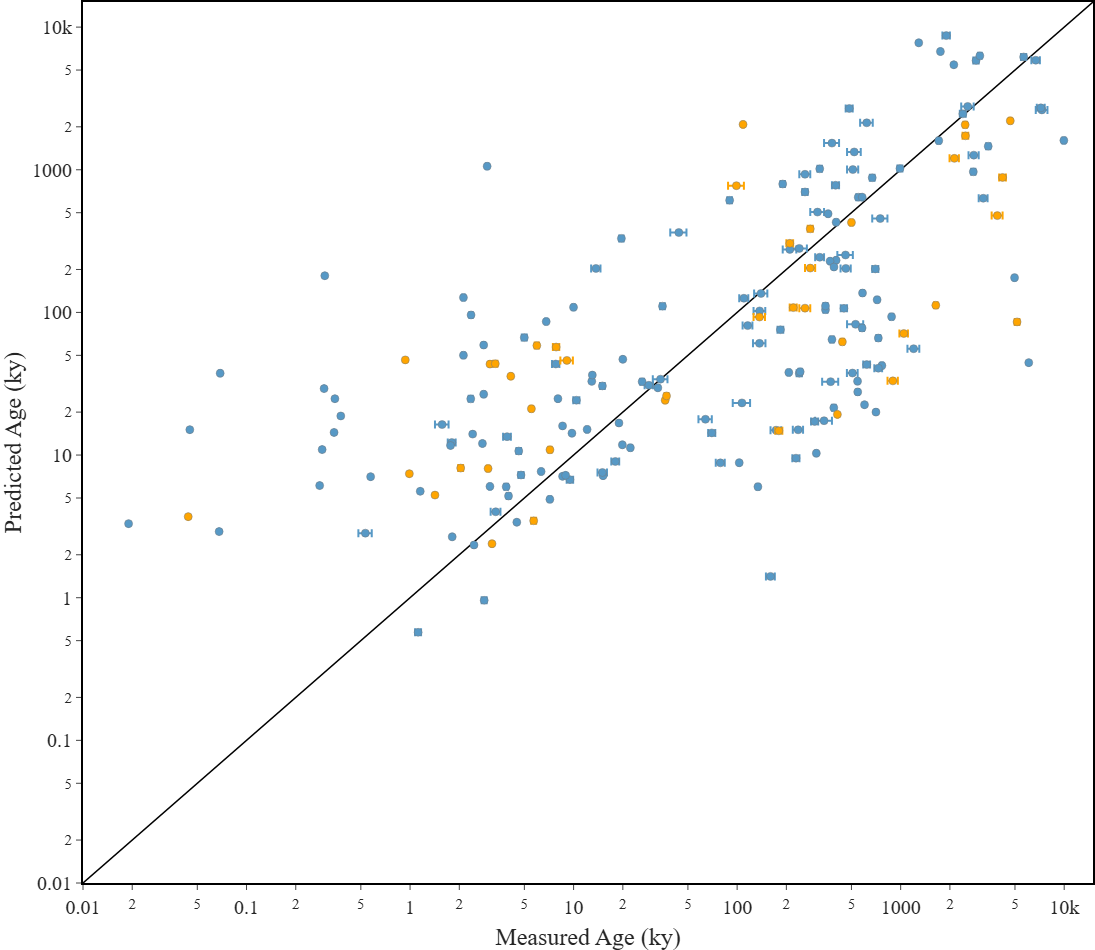

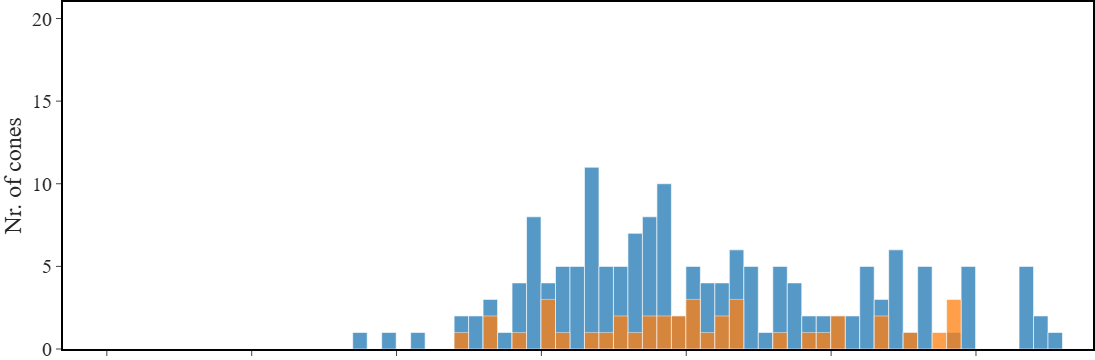

ShapeError: Expected object of length 40, got length: 161

In [24]:
### Plotting measured vs predicted graph
fig_pred_SVR = px.line(x=axis_range, y=axis_range, range_x=axis_range, range_y=axis_range, 
                   log_x=True, log_y=True, width=950, height=950)
fig_pred_SVR.update_traces(line_color='black', line_width=1.5)
fig_pred_SVR.add_trace(go.Scatter(x=df_SVR_cv_predicted.loc[:,target_parameter],
                              y=df_SVR_cv_predicted.loc[:,'{}_trainCV_{}'.format(SVR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_SVR_cv_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              hovertext=df_SVR_cv_predicted[['ConeName', 'Age', '{}_trainCV_{}'.format(SVR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_SVR_cv_predicted['ConeName'],
                              marker=dict(color='#5799c6', size=2, line=dict(color='#74797C')),
                              name='Training',
                              showlegend=False))
fig_pred_SVR.add_trace(go.Scatter(x=df_SVR_val_predicted.loc[:,target_parameter],
                              y=df_SVR_val_predicted.loc[:,'{}_val_{}'.format(SVR_method, target_parameter)],
                              mode='markers',
                              error_x = dict(
                                  type='data',
                                  array=df_SVR_val_predicted.loc[:,'AgeErrorReCalc1STD'].values,
                                  visible=True),
                              hovertext=df_SVR_val_predicted[['ConeName', 'Age', '{}_val_{}'.format(SVR_method, target_parameter)]],
                              hovertemplate=
                              'ConeName: %{text}' +
                              '<br>ConeAge: %{x:.2f} ky'+
                              '<br>ConePredAge: %{y:.2f} ky',
                              text=df_SVR_val_predicted['ConeName'],
                              marker=dict(color='#ffa500', size=2, line=dict(color='#74797C')),
                              name='Validation',
                              showlegend=False))
fig_pred_SVR.update_traces(marker=dict(size=8,line=dict(width=0.5)))
fig_pred_SVR.update_layout(xaxis = dict(title='Measured {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       yaxis = dict(title='Predicted {} ({})'.format(target_parameter, units),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                       font=dict(size=font_size, family=font_type),
                       margin_r=0, margin_t=0, margin_l=0, margin_b=0,
                       legend_itemsizing='constant',
                       legend=dict(yanchor='middle',
                                   y=0.96, x=0.01),
                       coloraxis_colorbar=dict(thicknessmode='pixels', 
                                               thickness=50,
                                               lenmode='pixels',
                                               len=150,
                                               yanchor='middle',
                                               y=0.2, x=0.8))
fig_pred_SVR.write_image(r'{}_{}_{}_Predition.svg'.format(inputName, predictor_parameter_text, SVR_method), format='svg', width=950, height=950, scale=1)
fig_pred_SVR.show()

### Plotting the distrubiton of predictions 
hist_pred_SVR = go.Figure()
hist_pred_SVR.add_trace(go.Histogram(x=np.log(df_SVR_cv_predicted.loc[:,'{}_trainCV_{}'.format(SVR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Pred Training'))
hist_pred_SVR.add_trace(go.Histogram(x=np.log(df_SVR_val_predicted.loc[:,'{}_val_{}'.format(SVR_method, target_parameter)]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Pred Validation'))
hist_pred_SVR.update_layout(barmode='overlay', showlegend=False, yaxis_range=hist_axis_rangeY, xaxis_range=np.log(axis_range), xaxis_showticklabels=False,
                                    margin_r=0, margin_t=0, margin_l=0, margin_b=0, width=950, 
                                    xaxis = dict(tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    yaxis = dict(title='Nr. of cones', tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    legend=dict(yanchor='top', y=0.99, xanchor='right', x=0.99),
                                    font=dict(size=font_size, family=font_type))
hist_pred_SVR.write_image(r'{}_TrainValidationSplit_{}_{}.svg'.format(inputName, predictor_parameter_text, SVR_method), format='svg', width=950, height=200, scale=1)
hist_pred_SVR.show()

fig_residual_SVR = px.scatter(
    df_SVR_cv_predicted,
    x=np.log(df_SVR_val_predicted[target_parameter]),
    y=np.log(df_SVR_val_predicted.loc[:,'{}_val_{}'.format(SVR_method, target_parameter)])-np.log(df_SVR_val_predicted[target_parameter]),
    width=1020, height=400)
fig_residual_SVR.add_hline(y=0, line_width=3, line_dash='dash', line_color='black')
fig_residual_SVR.update_layout(xaxis = dict(title='Log(absolute age)'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           yaxis = dict(title='Residuals'.format(),
                                    tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                           font=dict(size=font_size, family=font_type),
                           xaxis_range=[np.log(axis_range[0]),np.log(axis_range[1])],
                           yaxis_range=[-6.5,6.5]
                          )
fig_residual_SVR.write_image(r'{}_{}_{}_Predition_Residuals.svg'.format(inputName, predictor_parameter_text, SVR_method), format='svg', width=950, height=200, scale=1)
fig_residual_SVR.show()

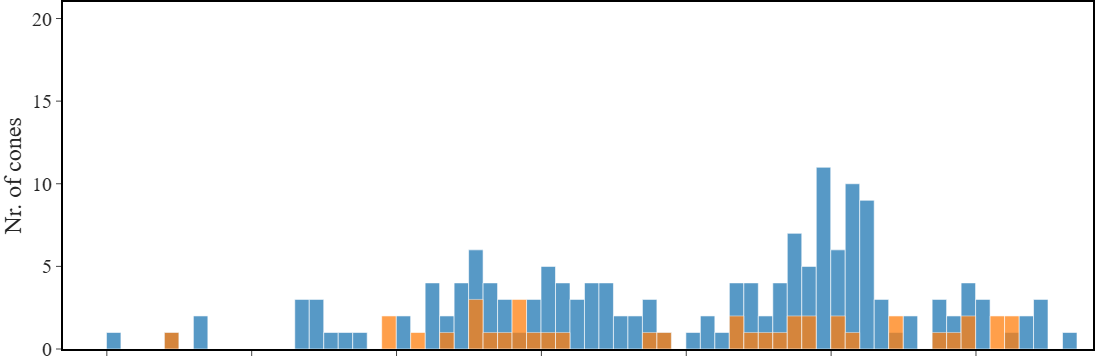

In [25]:
### Plotting training and validation data as a function of age
hist_train_validation = go.Figure()
hist_train_validation.add_trace(go.Histogram(x=np.log(df_scaled_train[target_parameter]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Training'))
hist_train_validation.add_trace(go.Histogram(x=np.log(df_scaled_val[target_parameter]),
                                             xbins=dict(start=np.log(axis_range[0]),end=np.log(axis_range[1]),size=0.2), opacity=0.75, name='Validation'))
hist_train_validation.update_layout(barmode='overlay', showlegend=False, yaxis_range=hist_axis_rangeY, xaxis_range=np.log(axis_range), xaxis_showticklabels=False,
                                    margin_r=0, margin_t=0, margin_l=0, margin_b=0, width=950, 
                                    xaxis = dict(tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    yaxis = dict(title='Nr. of cones', tickfont = dict(size=font_size), showline=True, linewidth=2, linecolor='black', mirror=True),
                                    legend=dict(yanchor='top', y=0.99, xanchor='right', x=0.99),
                                    font=dict(size=font_size, family=font_type))
hist_train_validation.write_image(r'{}_TrainValidationSplit_Original.svg'.format(inputName), format='svg', width=925, height=200, scale=1)
hist_train_validation.show()

In [ ]:
### Print results from all methods
print(PLSR_method, predictor_parameter_text, len(df_scaled_validation_X), PLScomp, np.mean(PLSR_cv_r2), np.mean(- PLSR_cv_MAPE*100), PLSR_val_r2, PLSR_val_MAPE*100, PLSR_val_spearmanR[0], PLSR_val_spearmanR[1], PLSR_excluded_r2, PLSR_excluded_MAPE*100, PLSR_excluded_spearmanR[0], PLSR_excluded_spearmanR[1])
print(MLR_method, predictor_parameter_text, len(df_scaled_validation_X), np.mean(MLR_cv_r2), np.mean(- MLR_cv_MAPE*100), MLR_val_r2, MLR_val_MAPE*100, MLR_val_spearmanR[0], MLR_val_spearmanR[1], MLR_excluded_r2, MLR_excluded_MAPE*100, MLR_excluded_spearmanR[0], MLR_excluded_spearmanR[1])
print(SVR_method, predictor_parameter_text, len(df_scaled_validation_X), c_value, gamma_value, epsilon_value, np.mean(SVR_cv_r2), np.mean(- SVR_cv_MAPE*100), SVR_val_r2, SVR_val_MAPE*100, SVR_val_spearmanR[0], SVR_val_spearmanR[1], SVR_excluded_r2, SVR_excluded_MAPE*100, SVR_excluded_spearmanR[0], SVR_excluded_spearmanR[1])